# NLP-midtern

總共有30個類別，每個類別都有1500筆資料。
每一筆資料都會提供headline跟short_description，請大家發揮想像力並結合上課所學，訓練出分類文章的模型。
資料當中也許會有一些特殊情形，需要大家好好處理，不然後面模型的訓練成效會不太好。

https://www.kaggle.com/competitions/ncnu-1112-nlp-midterm-project




# 1. 下載train和test資料

In [1]:
# !rm -rf NLP_practice
!git clone https://github.com/doudou030/NLP_practice.git
!cp NLP_practice/NLP_mid_data/train.csv train.csv
# Public data
!cp NLP_practice/NLP_mid_data/test.csv test.csv
# Private data
# !cp NLP_practice/NLP_mid_data/private_test.csv test.csv

fatal: destination path 'NLP_practice' already exists and is not an empty directory.


# 2. 導入需要的函式庫

In [2]:
# 模型及文字轉數字函示庫
import csv
import numpy as np
import pandas as pd
import torchtext
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

# 文字處理與清潔函示庫
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords 
from nltk.stem import WordNetLemmatizer
nltk.download('all')
from collections import Counter 

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Package abc is already up-to-date!
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Package alpino is already up-to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger is already up-
[nltk_data]    |       to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger_ru is already
[nltk_data]    |       up-to-date!
[nltk_data]    | Downloading package basque_grammars to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package basque_grammars is already up-to-date!
[nltk_data]    | Downloading package bcp47 to /root/nltk_data...
[nltk_data]    |   Package bcp47 is already up-to-dat

# 3. 讀train.csv

In [3]:
def read_train_data():
    '''
        read 'train.csv' and transform it to a list of dict
    
        output:
            train_data(list): contains a dict {'headline': str, 'short_description': str, 'category': str}
            classes(list): 30 claases name
    '''
    with open('train.csv', newline='') as csvfile:
        rows = csv.reader(csvfile)
        rows = list(rows)[1:]

    # save to train_data & set up classes mapping table
    train_data = []
    classes = []

    for row in rows:
        train_data.append({
            'id':                     row[0],
            'headline':               re.sub(r'[^\w\s]', '', row[1]).lower(),
            # 'short_description':      re.sub(r'[^\w\s]', '', row[2]).lower(),
            'category':               row[3]
        })
        if row[3] not in classes:
            classes.append(row[3])

    print("size of  data: {}\nsize of classes map: {}\n".format(len(train_data), len(classes)))
    return train_data, classes

# 4. 做pre-processing

In [4]:
#tokenizer
def en_tokenizer_yeild(data):
    '''
        for building torchtext.vocab.Vocab (English)
        it use get_tokenizer() function to tokenizer English sentences
        then yield tokens to build_vocab_from_iterator() function to generate Vocab

        Args:
            data (list[dict{'headline': str, 'short_description': str, 'category': str}]): it's from read_train_data()
    '''
    tokenizer = torchtext.data.utils.get_tokenizer("basic_english")
    for one_data in data:
        yield tokenizer(one_data['headline'])
        #yield tokenizer(one_data['short_description'])
        
def get_vocab(data):
    '''
        get Vocab object from torchtext
        
        Args:
            data(list of dict): from read_train_data()
        Outputs:
            vocab(Vocab object)
    '''
    vocab = torchtext.vocab.build_vocab_from_iterator(
        en_tokenizer_yeild(data),
        min_freq=5,
        special_first=True,
        specials=["<UNK>", "<END>", "<SOS>", "<PAD>"]
    )
    vocab.set_default_index( vocab["<UNK>"] )
    return vocab

def get_class_dict(classes):
    '''
        transform a list "classes" to 2 dict, (index to name) & (name to index)
        
        Args:
            classes (list): list of classes from read_train_data()
        outputs:
            CLASSES_INT_TO_STR(dict): index to name
            CLASSES_STR_TO_INT(dict): name to index
    '''
    classes_int_to_str = {}
    classes_str_to_int = {}
    for index, name in enumerate(classes):
        classes_int_to_str[index] = name
        classes_str_to_int[name]  = index
    return classes_int_to_str, classes_str_to_int

In [5]:
def data_preprocess(train_data, vocab, MAX_HEADLINE_LEN=30, MAX_SHORTDES_LEN=100):
    '''
        Args:
            train_data(list of dict): get from read_train_data()
            vocab(Vocab): get from get_vocab()
            MAX_HEADLINE_LEN(int, default=30)
            MAX_SHORTDES_LEN(int, default=100)
        Outputs:
            train_data(list of dict): ['headline'] and ['short_description'] all transform to tokens (including padding)
            
    '''
    for data in train_data:
        headline_tokens = vocab.lookup_indices(data['headline'].split())[:(MAX_HEADLINE_LEN-2)]
        # shortdes_tokens = vocab.lookup_indices(data['short_description'].split())[:(MAX_SHORTDES_LEN-2)]
        headline_tokens = [vocab['<SOS>']] + headline_tokens + [vocab['<END>']]
        # shortdes_tokens = [vocab['<SOS>']] + shortdes_tokens + [vocab['<END>']]
        headline_tokens = headline_tokens + [vocab['PAD']]*(MAX_HEADLINE_LEN-len(headline_tokens))
        # shortdes_tokens = shortdes_tokens + [vocab['PAD']]*(MAX_SHORTDES_LEN-len(shortdes_tokens))
        data['headline'] = headline_tokens
        # data['short_description'] = shortdes_tokens
    return train_data


In [6]:
# Run here
texts, classes = read_train_data()
CLASSES_INT_TO_STR, CLASSES_STR_TO_INT = get_class_dict(classes)
vocab = get_vocab(texts)
train_data = data_preprocess(texts, vocab, MAX_HEADLINE_LEN=30, MAX_SHORTDES_LEN=100)

size of  data: 30000
size of classes map: 30



In [7]:
# Check train data 
print(train_data[0])
print(CLASSES_INT_TO_STR)
print(CLASSES_STR_TO_INT)

{'id': '0', 'headline': [2, 4012, 198, 6, 1963, 8, 0, 0, 5, 1683, 6, 2795, 4332, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'category': 'BLACK VOICES'}
{0: 'BLACK VOICES', 1: 'BUSINESS', 2: 'COMEDY', 3: 'CRIME', 4: 'DIVORCE', 5: 'ENTERTAINMENT', 6: 'FOOD & DRINK', 7: 'GREEN', 8: 'HEALTHY LIVING', 9: 'HOME & LIVING', 10: 'IMPACT', 11: 'MEDIA', 12: 'PARENTING', 13: 'PARENTS', 14: 'POLITICS', 15: 'QUEER VOICES', 16: 'RELIGION', 17: 'SCIENCE', 18: 'SPORTS', 19: 'STYLE', 20: 'STYLE & BEAUTY', 21: 'TASTE', 22: 'TECH', 23: 'THE WORLDPOST', 24: 'TRAVEL', 25: 'WEDDINGS', 26: 'WEIRD NEWS', 27: 'WELLNESS', 28: 'WOMEN', 29: 'WORLD NEWS'}
{'BLACK VOICES': 0, 'BUSINESS': 1, 'COMEDY': 2, 'CRIME': 3, 'DIVORCE': 4, 'ENTERTAINMENT': 5, 'FOOD & DRINK': 6, 'GREEN': 7, 'HEALTHY LIVING': 8, 'HOME & LIVING': 9, 'IMPACT': 10, 'MEDIA': 11, 'PARENTING': 12, 'PARENTS': 13, 'POLITICS': 14, 'QUEER VOICES': 15, 'RELIGION': 16, 'SCIENCE': 17, 'SPORTS': 18, 'STYLE': 19, 'STYLE & BEAUTY': 20, 'TASTE': 21, 'TE

In [8]:
# categories table
print(classes)
int_classes = [CLASSES_STR_TO_INT[label] for label in classes]
print(int_classes)


['BLACK VOICES', 'BUSINESS', 'COMEDY', 'CRIME', 'DIVORCE', 'ENTERTAINMENT', 'FOOD & DRINK', 'GREEN', 'HEALTHY LIVING', 'HOME & LIVING', 'IMPACT', 'MEDIA', 'PARENTING', 'PARENTS', 'POLITICS', 'QUEER VOICES', 'RELIGION', 'SCIENCE', 'SPORTS', 'STYLE', 'STYLE & BEAUTY', 'TASTE', 'TECH', 'THE WORLDPOST', 'TRAVEL', 'WEDDINGS', 'WEIRD NEWS', 'WELLNESS', 'WOMEN', 'WORLD NEWS']
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]


In [9]:
# 設定train_texts
train_texts = [i["headline"] for i in train_data]
train_texts = np.array(train_texts)

# 設定label
train_labels = [CLASSES_STR_TO_INT[i['category']] for i in train_data]
train_labels = np.array(train_labels).reshape(-1, 1)
train_labels = to_categorical(train_labels, num_classes=30)

#check data type
print(type(train_texts))
print(type(train_labels))

print(train_texts.shape)
print(train_labels.shape)


<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
(30000, 30)
(30000, 30)


# 5. 建立model

In [10]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense, Embedding, Dropout, SimpleRNN, Softmax, Conv1D, GRU

model = tf.keras.Sequential([
      tf.keras.layers.Embedding(input_dim = 7500 , output_dim=256, input_length = len(train_texts[0])),
      
      tf.keras.layers.GRU(units=512, activation='tanh',return_sequences=True,dropout=0.5),
      tf.keras.layers.GRU(units=256, activation='tanh',return_sequences=True,dropout=0.5),
      tf.keras.layers.Dropout(0.5),
      # tf.keras.layers.LSTM(units=10, activation='tanh',return_sequences=True),
      tf.keras.layers.GlobalAveragePooling1D(),
      # tf.keras.layers.GRU(units=256, activation='tanh',return_sequences=True),
      # tf.keras.layers.LSTM(units=256, activation='tanh',return_sequences=True,dropout=0.4),
      tf.keras.layers.Dropout(0.4),
      tf.keras.layers.Dense(128, activation='relu'),
      tf.keras.layers.Dense(30, activation='softmax')
])

# 可以用的layer
# GlobalAveragePooling1D(),
# LSTM(units=60, activation='tanh')
# Dropout(0.25)
# SimpleRNN(units=60)

#'categorical_crossentropy' 'adam'
#loss= tf.keras.losses.SparseCategoricalCrossentropy(), optimizer=tf.keras.optimizers.Adam(1e-3)
model.compile(loss= 'categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 30, 256)           1920000   
                                                                 
 gru (GRU)                   (None, 30, 512)           1182720   
                                                                 
 gru_1 (GRU)                 (None, 30, 256)           591360    
                                                                 
 dropout (Dropout)           (None, 30, 256)           0         
                                                                 
 global_average_pooling1d (G  (None, 256)              0         
 lobalAveragePooling1D)                                          
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                        

# 6. 訓練model

In [11]:
import sklearn
from sklearn.model_selection import train_test_split
train_texts, val_texts, train_labels, val_labels = train_test_split(train_texts, train_labels, test_size=0.1)

In [12]:
from keras.callbacks import EarlyStopping
callback = EarlyStopping(monitor = "val_accuracy",patience = 5)

history = model.fit(train_texts, train_labels,
          batch_size = 64,
          epochs=100, 
          validation_data=(val_texts, val_labels),
          callbacks = [callback]
          )


Epoch 1/100
422/422 [==============================] - 37s 57ms/step - loss: 3.0549 - accuracy: 0.1204 - val_loss: 2.3346 - val_accuracy: 0.3163
Epoch 2/100
422/422 [==============================] - 8s 18ms/step - loss: 2.0939 - accuracy: 0.3781 - val_loss: 1.8780 - val_accuracy: 0.4460
Epoch 3/100
422/422 [==============================] - 8s 18ms/step - loss: 1.6589 - accuracy: 0.5047 - val_loss: 1.7547 - val_accuracy: 0.4880
Epoch 4/100
422/422 [==============================] - 6s 14ms/step - loss: 1.4182 - accuracy: 0.5705 - val_loss: 1.7484 - val_accuracy: 0.4887
Epoch 5/100
422/422 [==============================] - 7s 17ms/step - loss: 1.2572 - accuracy: 0.6189 - val_loss: 1.7277 - val_accuracy: 0.5103
Epoch 6/100
422/422 [==============================] - 7s 16ms/step - loss: 1.1177 - accuracy: 0.6594 - val_loss: 1.8312 - val_accuracy: 0.5053
Epoch 7/100
422/422 [==============================] - 8s 20ms/step - loss: 1.0110 - accuracy: 0.6891 - val_loss: 1.8979 - val_accuracy

# 7. 畫出訓練過程

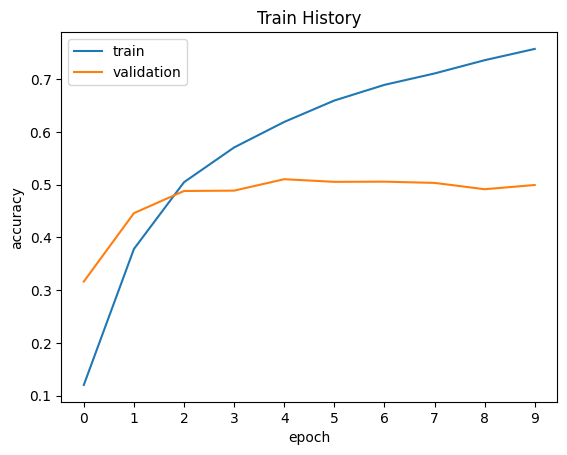

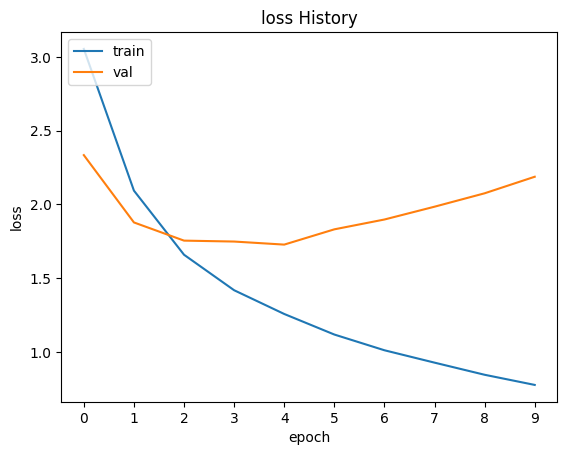

In [13]:
import matplotlib.pyplot as plt
def show_train_history(train_history):
    plt.plot(train_history.history['accuracy'])
    plt.plot(train_history.history['val_accuracy'])
    plt.xticks([i for i in range(0, len(train_history.history['accuracy']))])
    plt.title('Train History')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()
show_train_history(history)


def show_train_history_loss(train_history):
    plt.plot(train_history.history['loss'])
    plt.plot(train_history.history['val_loss'])
    plt.xticks([i for i in range(0, len(train_history.history['loss']))])
    plt.title('loss History')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()
    
show_train_history_loss(history)

# 8. 將test.csv透過model去預測並寫成submit.csv

In [14]:
def read_test_data():
    '''
        read 'test.csv' and transform it to a list of dict
    
        output:
            test_data(list): contains a dict {'headline': str, 'short_description': str}
            classes(list): 30 claases name
    '''
    with open('test.csv', newline='') as csvfile:
        rows = csv.reader(csvfile)
        rows = list(rows)[1:]

    # save to train_data & set up classes mapping table
    test_data = []

    for row in rows:
        test_data.append({
            'id':                     row[0],
            'headline':               re.sub(r'[^\w\s]', '', row[1]).lower(),
            # 'short_description':      re.sub(r'[^\w\s]', '', row[2]).lower(),
        })

    print("size of  data: {}\n".format(len(test_data)))
    return test_data



In [15]:
test_data = read_test_data()
preprocess_test_data = data_preprocess(test_data, vocab, MAX_HEADLINE_LEN=30)
test_data_list = [i['headline'] for i in preprocess_test_data]
print(test_data_list[0])

size of  data: 7500

[2, 135, 4761, 670, 937, 9, 2332, 138, 137, 0, 12, 472, 52, 3037, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [16]:
# 對test預測
predictions = np.argmax(model.predict(test_data_list), axis=-1)
predicted_categories = [CLASSES_INT_TO_STR[code] for code in predictions]

235/235 [==============================] - 2s 4ms/step


In [17]:
print(len(predictions))

7500


In [18]:
# 将预测结果转换为category
# CLASSES_INT_TO_STR
# CLASSES_STR_TO_INT

# 保存结果到submit.csv
submission = pd.DataFrame({'id': np.arange(0, len(predictions)),'category': predicted_categories})
submission.to_csv("sunbmit.csv", index=False)
print("write submit success!!")


write submit success!!
